In [8]:
# Imports and global functions

import dataclasses
import os.path
from typing import List

import PIL.Image
import io
import numpy as np
import torch as t
from IPython import display

from corenet.geometry import transformations
from corenet.geometry import voxelization
from corenet.visualization import scene_renderer
from corenet.visualization import voxel_renderer
from corenet import misc_util
from corenet.cc import fill_voxels

def disp(image: t.Tensor, lossless=False):
  """A helper function to display tensors as images."""
  if image.dtype == t.float32:
    image = (image * 255).clamp(0, 255).to(t.uint8)
  PIL.Image.fromarray(image.cpu().numpy()).save(buf := io.BytesIO(), format="webp", lossless=lossless, method=6)
  display.display(display.Image(data=buf.getvalue()))

Scene name: 'efe6cd70d5f1a2636c39834fcff598d1fa4525f8d73b115d5eb2f2210527f047'
Number of objects: 3
Images rendered from the chosen viewpoint (high and low realism).


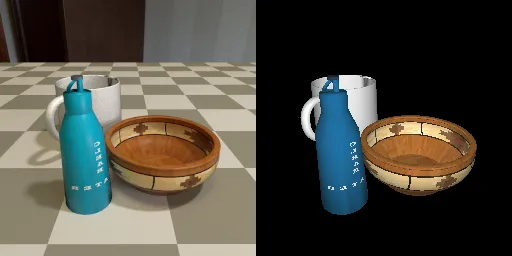

In [2]:
# Load a scene and display basic scene information
scene_path = (
    "~/prj/corenet/data/triplets.test/efe/efe6cd70d5f1a2636c39834fcff598d1fa4525f8d73b115d5eb2f2210527f047.npz")
scene_path = os.path.expanduser(scene_path)

@dataclasses.dataclass
class Scene:
  """A CoReNet scene that mirrors the structure the NPZ files."""
  scene_filename: str
  mesh_labels: List[str]
  mesh_filenames: List[str]
  mesh_visible_fractions: t.Tensor
  mesh_object_to_world_transforms: t.Tensor
  view_transform: t.Tensor
  camera_transform: t.Tensor
  opengl_image: t.Tensor
  pbrt_image: t.Tensor

scene_npz = np.load(scene_path)
scene = Scene(
    scene_filename=scene_npz["scene_filename"].item().decode(),
    mesh_labels=scene_npz["mesh_labels"].tolist(),
    mesh_filenames=scene_npz["mesh_filenames"].tolist(),
    mesh_visible_fractions = misc_util.to_tensor(scene_npz["mesh_visible_fractions"], t.float32),
    mesh_object_to_world_transforms = misc_util.to_tensor(scene_npz["mesh_object_to_world_transforms"], t.float32),
    view_transform = misc_util.to_tensor(scene_npz["view_transform"], t.float32),
    camera_transform = misc_util.to_tensor(scene_npz["camera_transform"], t.float32),
    opengl_image=misc_util.to_tensor(np.array(PIL.Image.open(io.BytesIO(scene_npz["opengl_image"]))), t.uint8),
    pbrt_image=misc_util.to_tensor(np.array(PIL.Image.open(io.BytesIO(scene_npz["pbrt_image"]))), t.uint8),
)

print(f"Scene name: '{scene.scene_filename}'")
print(f"Number of objects: {len(scene.mesh_filenames)}")
print("Images rendered from the chosen viewpoint (high and low realism).")
disp(t.cat([scene.pbrt_image, scene.opengl_image], dim=1))


In [3]:
# Load the scene's geometry
meshes_dir = "~/prj/corenet/data/shapenet_meshes"
meshes_dir = os.path.expanduser(meshes_dir)

scene_meshes = []
for label, file_name in zip(scene.mesh_labels, scene.mesh_filenames):
    mesh_npz_path = os.path.join(meshes_dir, label, f"{file_name}.npz")
    mesh_npz = np.load(mesh_npz_path)
    mesh_vertices = misc_util.to_tensor(mesh_npz["vertices"], t.float32)
    scene_meshes.append(mesh_vertices)

scene_vertices = []
for mesh, object_to_world in zip(scene_meshes, scene.mesh_object_to_world_transforms):
    scene_vertices.append(transformations.transform_mesh(mesh, object_to_world))
scene_vertices = t.cat(scene_vertices)

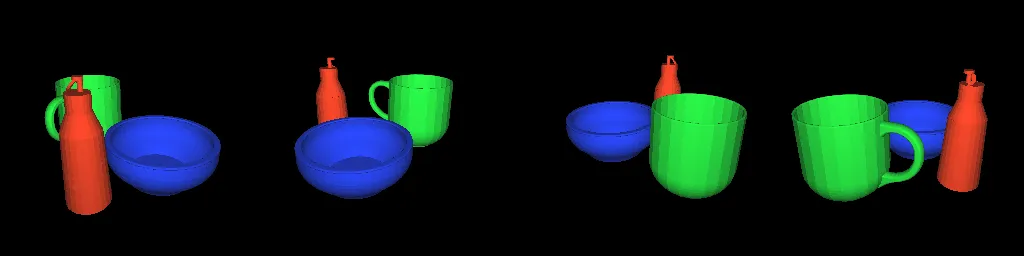

In [4]:
# Render the scene, coloring each object differently. Use several view points, first one matches camera.
num_views = 4

num_objects = len(scene_meshes)
object_colors = t.tensor(((0.8, 0.2, 0.1), (0.1, 0.8, 0.2), (0.1,0.2, 0.8)))
assert num_objects <= len(object_colors)
matrial_ids = misc_util.dynamic_tile(t.tensor([v.shape[0] for v in scene_meshes]))

images = []
world2screen = scene.camera_transform @ scene.view_transform
for rotation in range(num_views):
  rotation = rotation * 2 * np.pi / num_views
  rotation = transformations.chain([
      transformations.translate((0.5,) * 3),
      transformations.rotate(rotation, (0, 1, 0)),
      transformations.translate((-0.5,) * 3),  # Center the scene before rotating
  ])
  camera_matrix = world2screen @ rotation
  images.append(scene_renderer.render_scene(
      scene_vertices, camera_matrix, diffuse_coefficients=object_colors,
      material_ids=matrial_ids))
disp(t.cat(images, dim=1))

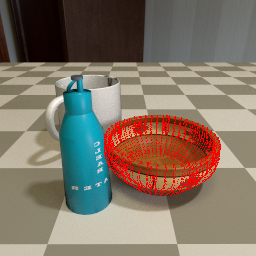

In [5]:
# Project the vertices of an object onto the screen, visualize by splatting onto an image
object_index = 2
h, w, _ = scene.pbrt_image.shape
object_2_world = scene.mesh_object_to_world_transforms[object_index]
world_to_view = scene.view_transform
view_to_image = scene.camera_transform
image_to_pixels = (transformations.scale((w / 2, h / 2, 1)) @
                   transformations.translate((1, 1, 0)))
camera_matrix = transformations.chain([
    image_to_pixels,
    view_to_image,
    world_to_view,
    object_2_world
])
triangle_vertices = scene_meshes[object_index].reshape([-1, 3])
projected_points = transformations.transform_points(triangle_vertices, camera_matrix)
image = scene.pbrt_image.clone()
xx, yy, _ = projected_points.to(t.int64).T
image[yy, xx] = t.tensor((255, 0, 0), dtype=t.uint8)
disp(image, lossless=True)

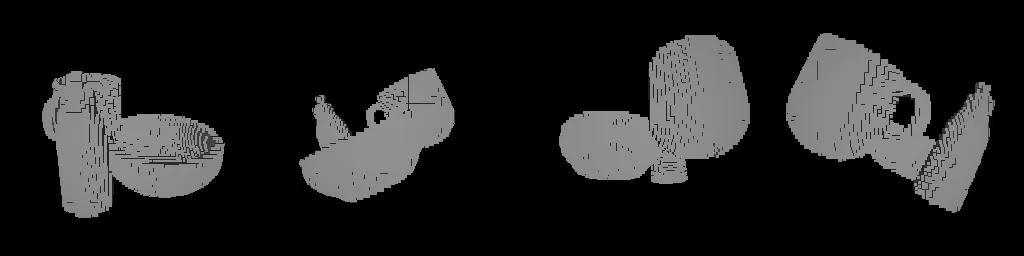

In [6]:
# Voxelize the scene and render from several view points (first one matches camera)
# Note that the axis rotation is up in view space, thus rotation look unnatural
D, H, W = 64, 64, 64
num_views = 4
voxelization_matrix = transformations.scale((W, H, D)) @ scene.view_transform
grid = voxelization.voxelize_mesh(
    scene_vertices, scene_vertices.shape[0:1], (D, H, W), voxelization_matrix)
grid = grid[0].to(t.int32)

images = []
voxel_to_view_matrix=transformations.scale((1/W, 1/H, 1/D))
for rotation in range(num_views):
  rotation = rotation * 2 * np.pi / num_views
  rotation = transformations.chain([
      transformations.translate((0.5,) * 3),
      transformations.rotate(rotation, (0, 1, 0)),
      transformations.translate((-0.5,) * 3),  # Center the scene before rotating
  ])
  camera_matrix = scene.camera_transform @ rotation
  images.append(voxel_renderer.render_voxel_grid(
      grid, camera_matrix, voxel_to_view_matrix=voxel_to_view_matrix))
disp(t.cat(images, dim=1))


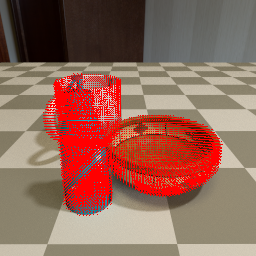

In [7]:
# Project the centers of the "full" voxels onto an image of the scene

# The transfotmations
voxel_index_to_center_coordinates = transformations.translate((0.5,) * 3)
voxel_to_view = transformations.scale((1/W, 1/H, 1/D))
view_to_image = scene.camera_transform
h, w, _ = scene.pbrt_image.shape
image_to_pixels = (transformations.scale((w/2, h/2, 1)) @ 
                   transformations.translate((1.0, 1.0, 0)))
project_centers_transform = transformations.chain([
    image_to_pixels,
    view_to_image,
    voxel_to_view,
    voxel_index_to_center_coordinates
])

# Fill isolated pockets of empty space inside the objects
filled_grid = fill_voxels.fill_inside_voxels_gpu(grid[None])[0]

# Project the voxel centers to the image
zz, yy, xx = filled_grid.nonzero(as_tuple=False).to(t.float32).to(project_centers_transform.device).T
full_voxel_indices = t.stack([xx, yy, zz], dim=-1)
pixel_coordinates = transformations.transform_points(full_voxel_indices, project_centers_transform)
xx, yy, _ = pixel_coordinates.to(t.int64).T
image = scene.pbrt_image.clone()
image[yy, xx] = t.tensor((255, 0, 0), dtype=t.uint8)
disp(image, lossless=True)